# Imports 

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from skimage import io, color, exposure
from skimage.filters import prewitt, median, gaussian
from skimage.morphology import disk, dilation, erosion, closing, opening 
from skimage.transform import rescale

from sklearn.decomposition import PCA, IncrementalPCA

from pystackreg import StackReg

# Load images

In [2]:
# Define experiment and path
exp = 'Exp0_20feb', '01'

In [6]:
exp_path = os.path.abspath(os.path.join(
    os.getcwd(),
    os.pardir,
    'experiments',
    exp[0]
))

# input images path
images_path = os.path.join(exp_path,'images/',exp[1]) 
# save processed images
out_path = os.path.join(exp_path,'processed/') 

# list of images
imgs = list(io.imread_collection(images_path+'/*.bmp'))

In [20]:
processed_path = os.path.abspath(os.path.join(
    os.getcwd(),
    os.pardir,
    'datasets',
    'processed',
    'train'
))
imgs = list(io.imread_collection(processed_path+'/*.bmp'))
imgs2 = list(io.imread_collection('train/*.bmp'))

In [27]:
img1 = imgs[50].astype('int16')
img2 = imgs2[50].astype('int16')

In [31]:
img1.sum() - img2.sum()

-716257

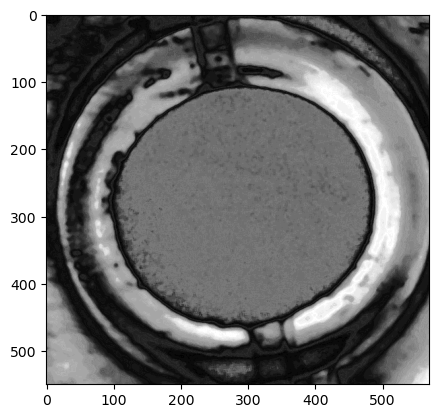

In [29]:
plt.imshow(img1-img2,cmap='gray')

# Plot Utility Functions

In [4]:
def compare_plot(imgs,cmap='gray'):
    N = len(imgs)
    figs, axs = plt.subplots(1,N,figsize=(20,20))
    for n in range(N):
        axs[n].imshow(imgs[n],cmap=cmap)
    plt.show()
    
def hist(img, bins=20):
    plt.hist(img.ravel(), bins=bins)
    plt.show()
    
def plot(img, cmap='gray'):
    plt.imshow(img, cmap=cmap)
    plt.show()
    
def save_plot(img, name, save_dir=out_path, cmap='gray'):
    plt.imshow(img, cmap=cmap)
    plt.savefig(os.path.join(save_dir,name))
    plt.show()

# (Rigid) Registration

In [6]:
# Define permanent reference image
ref = img.astype('int16')

NameError: name 'img' is not defined

In [69]:
cmap = 'jet'

In [70]:
mov = img.astype('int16')

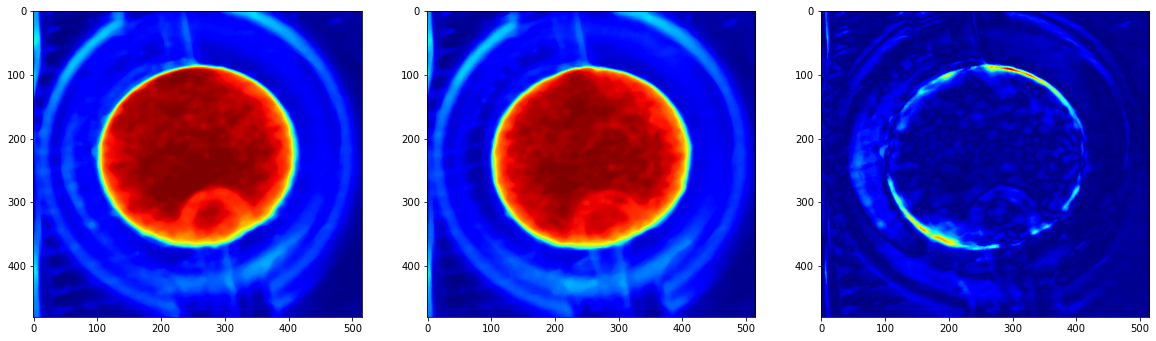

In [75]:
fig, axs = plt.subplots(1,3,figsize=(20,20))
axs[0].imshow(ref,cmap=cmap)
axs[1].imshow(mov,cmap=cmap)
axs[2].imshow(abs(mov-ref),cmap=cmap)
plt.show()

In [72]:
sr = StackReg(StackReg.RIGID_BODY)
out_rot = sr.register_transform(ref,mov).astype('uint8')

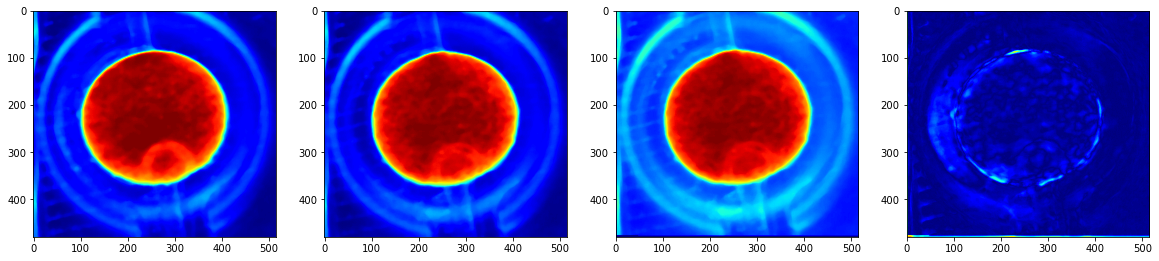

In [76]:
fig, axs = plt.subplots(1,4,figsize=(20,20))
axs[0].imshow(ref,cmap=cmap)
axs[1].imshow(mov,cmap=cmap)
axs[2].imshow(out_rot,cmap=cmap)
axs[3].imshow(abs(out_rot-ref),cmap=cmap)
plt.show()

In [74]:
print(f"{'Control:':13} {np.sum(abs(mov-ref)) :>9}")
print(f"{'Registration:':13} {np.sum(abs(out_rot-ref)) :>9}")
print(f"{'Difference:':13} {np.sum(abs(mov-ref)) - np.sum(abs(out_rot-ref)) :>9}")

Control:        1369680
Registration:   1096277
Difference:      273403


# Pre-processing

In [258]:
# Crop
def crop(img):
    return img[ : , 185:700]

# Takes RGB-image
def white_balance(img):
    white_ref = img[150:300,400:500]
    mean = white_ref.mean(axis=0).mean(axis=0)
    add = (np.array([255,255,255])-mean).astype('uint8')
    
    img2 = img.astype('uint16')
    img2 += add
    #img2 = np.clip(img2,0,255)
    img2 = stretch(0,255,img2)
    return img2

def stretch(v_min_d, v_max_d, img):
    v_min = np.min(img)
    v_max = np.max(img)
    g = ((v_max_d - v_min_d) / (v_max - v_min)) * (img - v_min) + v_min_d
    return np.round(g).astype('uint8')


# Grayscaling and gamma mapping
def coloring(img):
    img = (color.rgb2gray(img)*255).astype('uint8')
    #img = exposure.adjust_gamma(img, 0.7)
    return img


# Rescale / downsample ?
def scale(img, factor=2):
    return rescale(img, 1/factor)


# Noise filtering
def filtering(img):
    #img = prewitt(img)
    #img = gaussian(img, sigma=4)
    img = median(img, np.ones((10,10)) )
    return img


In [262]:
processed_imgs = []
for img in imgs:
    img = white_balance(img)
    img = crop(img)
    img = coloring(img)
    #img = filtering(img)
    img = scale(img,factor=1)
    processed_imgs.append(img)

# Baseline Image

### Mean and Variance image

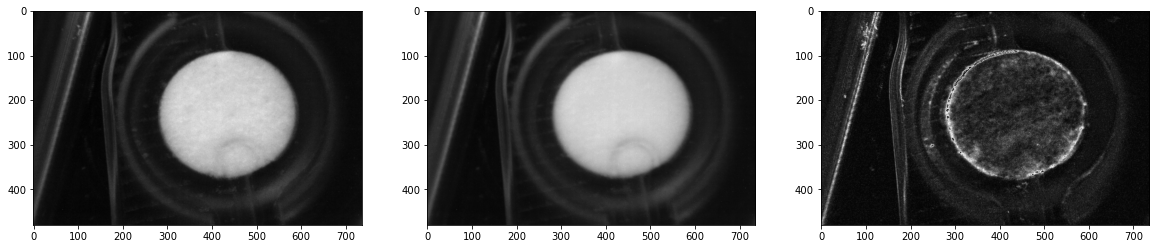

In [495]:
gray = []
for img in imgs:
    gray.append( (color.rgb2gray(img)*255).astype('uint8') )
summary_imgs = np.array(gray)

mean = summary_imgs.mean(axis=0).astype(np.uint8)
std = summary_imgs.std(axis=0).astype(np.uint8)

compare_plot([summary_imgs[0], mean, std**2],cmap='gray')

### PCA

In [375]:
img_shape = processed_imgs[0].shape
X = np.array(processed_imgs)
X = X.reshape( (X.shape[0], -1) )

In [407]:
n_components = 3
pca = PCA(n_components=n_components) # , svd_solver='randomized'
pca.fit(X)

PCA(n_components=3)

In [408]:
components = pca.transform(X)
projected = pca.inverse_transform(components)
print(components.shape)
print(projected.shape)

(10, 3)
(10, 247200)


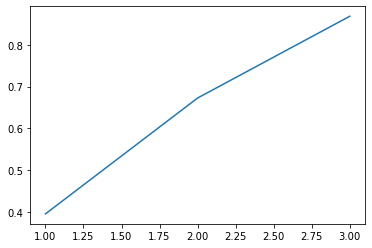

In [409]:
plt.plot(np.arange(1,n_components+1),np.cumsum(pca.explained_variance_ratio_))
plt.show()

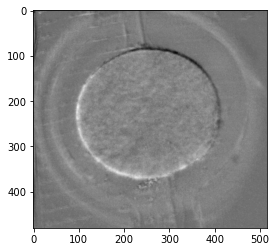

In [410]:
# Visualize the principal components
pc_index = 0
plt.imshow(pca.components_[pc_index].reshape(img_shape),cmap='gray')
plt.show()

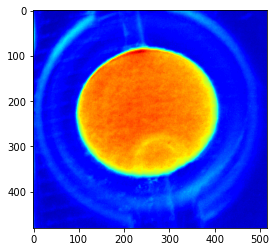

In [418]:
# Projected
plt.imshow(projected[8].reshape(img_shape),cmap='jet')
plt.show()

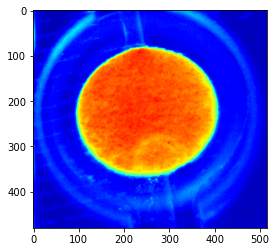

In [419]:
# First image
plt.imshow(np.array(processed_imgs[8]),cmap='jet')
plt.show()

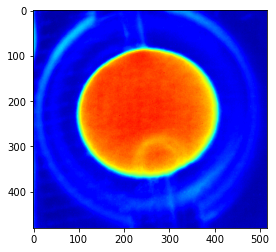

In [413]:
# Comapre with mean
plt.imshow(np.array(processed_imgs).mean(axis=0),cmap='jet')
plt.show()

# Segmentation

In [391]:
# Binarize with threshold, T
def binarize(img, low=0, high=256):
    mask = (img>low) & (img<high)
    return mask

# Calculate BLOBs
def BLOB(img):
    blobs = ...
    return blobs

# Morphological operations
def morph(img):
    fp1 = disk(7)
    img = closing(img, fp1)
    fp2 = disk(3)
    img = erosion(img, fp2)
    return img